# 1. Importing Dependencies


## 1.1 Importing Dependency Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
storage = {
    "model": None,
    "scaler": None,
    "means": None
}

## 1.2. Mounting Google Drive

## 1.3 Loading the Main Data

In [3]:
columns = ['Serial', 'AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA',
       'AgeAtCalvingInDays', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
       'MostRecentMotionScore', 'AverageBodyScore', 'AverageMotionScore',
       'InbreedingCoefficient', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
       'MilkFat', 'MilkProtein', 'StillBirth', 'Abortion', 'DIMAtBreeding',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'LengthInDays',
       'DaysOpen', 'TimesBred', 'Lameness', 'Mastitis', 'Ketosis',
       'RetainedPlacenta', 'DisplacedAbomasum', 'Winter', 'Spring', 'Summer',
       'Fall']

In [4]:
# Detect outliers in numerical columns
numeric_columns = ['AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA', 'AgeAtCalvingInDays',
       'AgeAtCalvingInMonths', 'MostRecentBodyScore', 'MostRecentMotionScore',
       'AverageBodyScore', 'AverageMotionScore', 'InbreedingCoefficient',
       'PregnancyLengthMonths', 'Milk',
       'MilkDays', 'MilkFat', 'MilkProtein',
       'DIMAtBreeding', 'Lactation',
       'LengthInDays', 'DaysOpen', 'TimesBred', 'AverageMilk', 'ECM',
       'FatProteinRatio']

good_features = ['Serial', 'AgeAtCalvingInDays', 'AverageBodyScore',
       'AverageMotionScore', 'InbreedingCoefficient', 'StillBirth', 'Abortion',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'DaysOpen', 'TimesBred',
       'Lameness', 'Mastitis', 'Ketosis', 'RetainedPlacenta',
       'DisplacedAbomasum', 'Winter', 'Spring', 'Summer', 'Fall',
       'AverageMilk', 'ECM', 'FatProteinRatio']

In [5]:
# Use the Pandas library to read the CSV file
data = pd.read_csv('days-open-v9.csv', dtype= {'Serial': str}, names= columns)

In [6]:
data['Serial'].nunique()

5557

In [7]:
data.columns

Index(['Serial', 'AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA',
       'AgeAtCalvingInDays', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
       'MostRecentMotionScore', 'AverageBodyScore', 'AverageMotionScore',
       'InbreedingCoefficient', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
       'MilkFat', 'MilkProtein', 'StillBirth', 'Abortion', 'DIMAtBreeding',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'LengthInDays',
       'DaysOpen', 'TimesBred', 'Lameness', 'Mastitis', 'Ketosis',
       'RetainedPlacenta', 'DisplacedAbomasum', 'Winter', 'Spring', 'Summer',
       'Fall'],
      dtype='object')

In [8]:
data['AverageMotionScore'].describe()

count    5444.000000
mean        2.104669
std         0.810585
min         1.000000
25%         1.500000
50%         2.000000
75%         2.500000
max         5.000000
Name: AverageMotionScore, dtype: float64

In [9]:
def remove_invalid_records(data, condition):
    # Find invalid records based on the condition
    invalid_records = data[~condition]
    
    # Get the serial numbers of invalid records
    invalid_serials = invalid_records['Serial'].unique()
    
    # Remove all records with the same serial numbers
    cleaned_data = data[~data['Serial'].isin(invalid_serials)]
    
    return cleaned_data

# Example usage:
# Define your condition
condition = (
    (data['AgeAtCalvingInMonthsA'] > 20) &
    (data['AgeAtCalvingInMonths'] > 20) &
    (data['DaysOpen'] > 60) 
)

# Call the function
cleaned_data = remove_invalid_records(data, condition)


In [10]:
data['Serial'].nunique()

5557

In [11]:
cleaned_data

,Serial,AgeAtCalvingInDaysA,AgeAtCalvingInMonthsA,AgeAtCalvingInDays,AgeAtCalvingInMonths,MostRecentBodyScore,MostRecentMotionScore,AverageBodyScore,AverageMotionScore,InbreedingCoefficient,...,TimesBred,Lameness,Mastitis,Ketosis,RetainedPlacenta,DisplacedAbomasum,Winter,Spring,Summer,Fall
8,3251370020200020,1661,55,2090,69,NaN,NaN,NaN,NaN,0.000000,...,1,0,0,0,0,0,1,0,0,0
9,3251370022700030,1499,49,1942,64,NaN,NaN,NaN,NaN,0.000000,...,3,0,0,0,0,0,0,0,1,1
10,3251370022700030,1942,64,2432,80,NaN,NaN,NaN,NaN,0.000000,...,4,0,0,0,0,0,1,0,0,0
11,3251370022700030,2432,80,2812,92,NaN,NaN,NaN,NaN,0.000000,...,2,0,0,0,0,0,1,0,0,0
12,3251370022700030,2812,92,3298,108,NaN,NaN,NaN,NaN,0.000000,...,5,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16457,3251393101906930,1009,33,1382,45,4.00,3.0,4.175000,2.5,NaN,...,1,0,0,0,0,0,0,0,0,1
16458,3251389081106010,1488,48,1722,56,4.00,4.0,4.178571,4.0,4.199220,...,2,0,0,0,0,0,0,0,1,0
16462,3251391022301370,726,24,1073,35,4.00,NaN,4.250000,NaN,NaN,...,3,0,0,0,0,0,0,1,0,0
16467,3251388033002190,1991,66,2277,75,3.50,NaN,4.305556,NaN,0.720215,...,3,0,0,0,1,0,0,0,1,1


In [12]:
# logical_data = logical_data[(logical_data['DaysOpen'] >= 70) & (logical_data['DaysOpen'] <= 365)]
cleaned_data.shape

(7639, 33)

In [13]:
data = cleaned_data

# 2. Data Processing
In this part we use process the data, merge it disorders data and then clean the data, remove the outliers and normalize it to be ready for the model

In [14]:
data['AverageMilk'] = data['Milk'] / data['MilkDays']

In [15]:
mask = np.isnan(data["MilkFat"]) | np.isnan(data["MilkProtein"]) | np.isnan(data["Milk"])

data["ECM"] = np.nan
data.loc[~mask, "ECM"] = 0.327 * data["Milk"] + 12.95 * data["MilkFat"] + 7.65 * data["MilkProtein"]



In [16]:

data["FatProteinRatio"] = np.nan
data.loc[~mask, "FatProteinRatio"] = data["MilkFat"] / data["MilkProtein"]


In [17]:
feature_descriptions = {
    'AgeAtCalvingInDaysA': 'Age at calving in days (Category A)',
    'AgeAtCalvingInMonthsA': 'Age at calving in months (Category A)',
    'AgeAtCalvingInDays': 'Age at calving in days',
    'AgeAtCalvingInMonths': 'Age at calving in months',
    'MostRecentBodyScore': 'Most recent body score',
    'MostRecentMotionScore': 'Most recent motion score',
    'AverageBodyScore': 'Average body score',
    'AverageMotionScore': 'Average motion score',
    'InbreedingCoefficient': 'Inbreeding coefficient',
    'PregnancyLengthMonths': 'Pregnancy length in months',
    'Milk': 'Milk yield',
    'MilkDays': 'Days of milk production',
    'MilkFat': 'Milk fat content',
    'MilkProtein': 'Milk protein content',
    'StillBirth': 'Still birth (0 or 1)',
    'Abortion': 'Abortion (0 or 1)',
    'DIMAtBreeding': 'Days in milk at breeding',
    'Lactation': 'Lactation number',
    'MultiBirth': 'Multiple birth (0 or 1)',
    'NaturalBreeding': 'Natural breeding (0 or 1)',
    'LengthInDays': 'Length in days',
    'DaysOpen': 'Days open',
    'TimesBred': 'Number of times bred',
    'Lameness': 'Lameness score',
    'Mastitis': 'Mastitis score',
    'Ketosis': 'Ketosis score',
    'RetainedPlacenta': 'Retained placenta (0 or 1)',
    'DisplacedAbomasum': 'Displaced abomasum (0 or 1)',
    'Winter': 'Winter season (0 or 1)',
    'Spring': 'Spring season (0 or 1)',
    'Summer': 'Summer season (0 or 1)',
    'Fall': 'Fall season (0 or 1)',
    'AverageMilk': 'Average milk yield',
    'ECM': 'Energy-corrected milk yield',
    'FatProteinRatio': 'Fat to protein ratio'
}

In [18]:


def categorize_feature_type(series):
    if series.nunique() == 2 and (0 in series.unique()) and (1 in series.unique()):
        return 'Binary'
    elif np.issubdtype(series.dtype, np.number):
        return 'Numeric'
    else:
        return 'Nominal'

def generate_feature_description_table(data):
    # Calculate % of missing values
    missing_percentage = (data.isnull().sum() / len(data)) * 100

    # Get data types
    data_types = data.apply(categorize_feature_type)


    # Calculate summary statistics
    summary_stats = data.describe().transpose()

    # Combine all information into a table
    feature_table = pd.concat([summary_stats, missing_percentage, data_types], axis=1)
    feature_table.columns = ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', '% Missing', 'Data Type']
    feature_table['Description'] = feature_table.index.map(feature_descriptions)

    return feature_table


In [19]:
stat = generate_feature_description_table(data[good_features])
stat.to_csv('features.csv')

In [20]:
data.columns

Index(['Serial', 'AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA',
       'AgeAtCalvingInDays', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
       'MostRecentMotionScore', 'AverageBodyScore', 'AverageMotionScore',
       'InbreedingCoefficient', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
       'MilkFat', 'MilkProtein', 'StillBirth', 'Abortion', 'DIMAtBreeding',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'LengthInDays',
       'DaysOpen', 'TimesBred', 'Lameness', 'Mastitis', 'Ketosis',
       'RetainedPlacenta', 'DisplacedAbomasum', 'Winter', 'Spring', 'Summer',
       'Fall', 'AverageMilk', 'ECM', 'FatProteinRatio'],
      dtype='object')

In [21]:


outliers = data[numeric_columns].apply(lambda x: (x - x.mean()).abs() > 3 * x.std())
outlier_counts = outliers.sum()

outlier_counts


AgeAtCalvingInDaysA      112
AgeAtCalvingInMonthsA    113
AgeAtCalvingInDays       114
AgeAtCalvingInMonths     114
MostRecentBodyScore       28
MostRecentMotionScore      0
AverageBodyScore          38
AverageMotionScore        21
InbreedingCoefficient     99
PregnancyLengthMonths    311
Milk                       9
MilkDays                  26
MilkFat                   13
MilkProtein                8
DIMAtBreeding            177
Lactation                 79
LengthInDays             127
DaysOpen                 177
TimesBred                 84
AverageMilk                4
ECM                       13
FatProteinRatio            4
dtype: int64

In [22]:
standard_data = data.copy()  # Create a copy of the original DataFrame
# Handling outliers
for column in numeric_columns:
    mean = standard_data[column].mean()
    std = standard_data[column].std()
    upper_bound = mean + 3 * std
    lower_bound = mean - 3 * std

    standard_data.loc[:, column] = standard_data.loc[:, column].clip(lower=lower_bound, upper=upper_bound)



In [23]:
# Check the number of missing values in each column
missing_values_count = standard_data.isnull().sum()
print(missing_values_count)


Serial                      0
AgeAtCalvingInDaysA         0
AgeAtCalvingInMonthsA       0
AgeAtCalvingInDays          0
AgeAtCalvingInMonths        0
MostRecentBodyScore      1990
MostRecentMotionScore    5051
AverageBodyScore         1990
AverageMotionScore       5051
InbreedingCoefficient    3788
PregnancyLengthMonths       0
Milk                     5948
MilkDays                 5948
MilkFat                  5948
MilkProtein              5948
StillBirth                  0
Abortion                    0
DIMAtBreeding               0
Lactation                   0
MultiBirth                  0
NaturalBreeding             0
LengthInDays                0
DaysOpen                    0
TimesBred                   0
Lameness                    0
Mastitis                    0
Ketosis                     0
RetainedPlacenta            0
DisplacedAbomasum           0
Winter                      0
Spring                      0
Summer                      0
Fall                        0
AverageMil

In [24]:
import pandas as pd

filled_data = standard_data.copy()  # Create a copy of the original DataFrame


mean_values = {}  # Dictionary to store the mean values

# fill NaN values with mean value of each column
for col in numeric_columns:
    mean_val = filled_data[col].mean()
    mean_values[col] = mean_val  # Save the mean value for each column
    filled_data[col].fillna(mean_val, inplace=True)

storage["means"] = mean_values

In [25]:
# # To have good features
filled_data = filled_data[good_features]


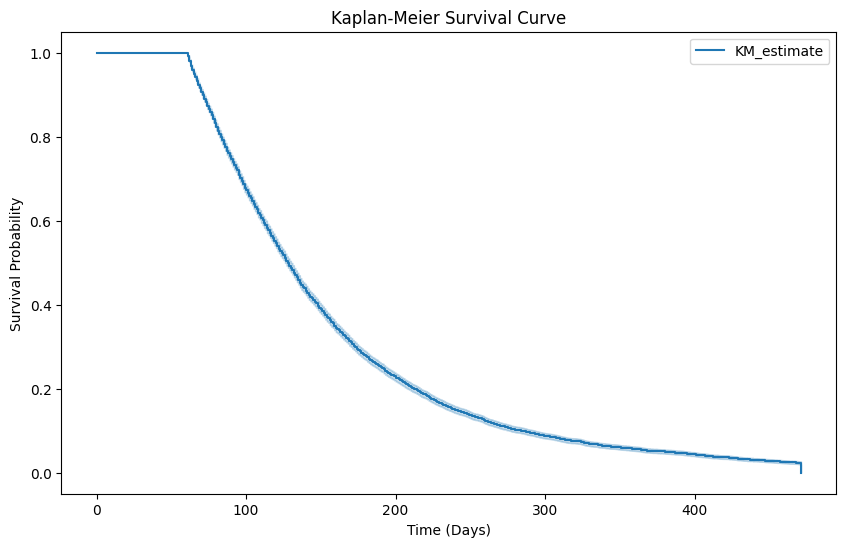

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

cox_data = filled_data.drop('Serial', axis=1).copy()
cox_data['Event'] = 1
# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier estimator to your data
kmf.fit(durations=cox_data['DaysOpen'], event_observed=cox_data['Event'])

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.show()


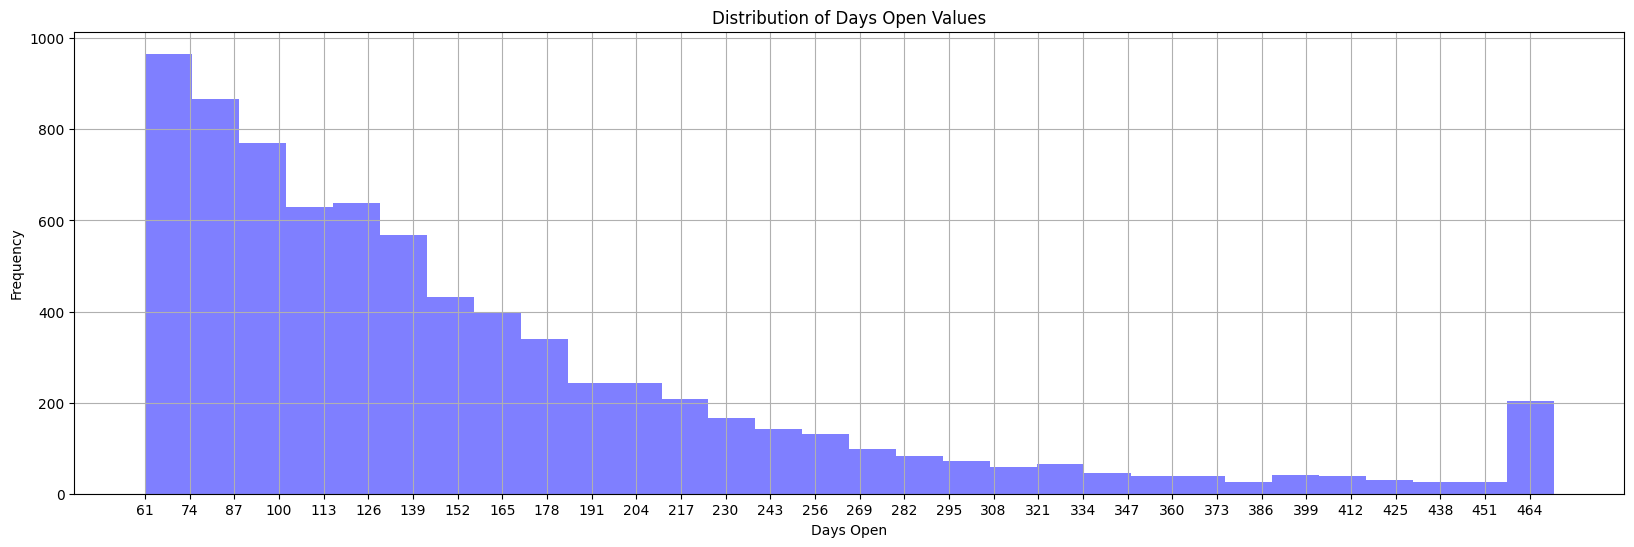

In [27]:
# Assuming y_test is a numpy array
plt.figure(figsize=(20, 6))

# Specify the number of bins and the range of values
num_bins = 30
range_min = min(filled_data['DaysOpen'])
range_max = max(filled_data['DaysOpen'])

# Plot the distribution of y_test in blue
plt.hist(filled_data['DaysOpen'], bins=np.linspace(range_min, range_max, num_bins+1), alpha=0.5, color='blue', label='True (y_test)')

# Set the x-axis ticks to be more accurate
plt.xticks(np.arange(range_min, range_max+1, (range_max-range_min)//num_bins))

plt.title('Distribution of Days Open Values')
plt.xlabel('Days Open')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()


In [28]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

# Set the dark theme
pio.templates.default = "plotly_dark"

In [29]:
# # Box Plots (Horizontal)
# fig = go.Figure()
# fig.add_trace(go.Box(x=filled_data['DaysOpen'], name='Days Open', orientation='h'))  # Set orientation to 'h' for horizontal
# fig.update_layout(
#     title='Days Open Box Plot',
#     font=dict(color='white'),  # Set font color
#     xaxis=dict(title='Days Open', color='white'),  # Set x-axis title and font color
#     yaxis=dict(tickfont=dict(color='white')),  # Set y-axis tick font color
# )
# fig.show()


In [30]:
# # Box Plots (Horizontal)
# fig = go.Figure()
# fig.add_trace(go.Box(x=filled_data['AgeAtCalvingInDays'], name='AgeAtCalvingInDays', orientation='h'))  # Set orientation to 'h' for horizontal
# fig.update_layout(
#     title='AgeAtCalvingInDays Box Plot',
#     font=dict(color='white'),  # Set font color
#     xaxis=dict(title='AgeAtCalvingInDays', color='white'),  # Set x-axis title and font color
#     yaxis=dict(tickfont=dict(color='white')),  # Set y-axis tick font color
# )
# fig.show()


In [31]:
# # Seasons Pie Chart
# season_counts = filled_data[['Winter', 'Spring', 'Summer', 'Fall']].sum()
# fig = go.Figure(data=[go.Pie(labels=season_counts.index, values=season_counts.values)])
# fig.update_layout(
#     title='Seasons Pie Chart',
#     font=dict(color='white'),  # Set font color
# )
# fig.show()

In [32]:
# import plotly.figure_factory as ff
# import numpy as np

# # Select numeric columns for correlation matrix
# numeric_columns = filled_data.select_dtypes(include=[np.number])

# # Compute correlation matrix
# corr_matrix = numeric_columns.corr()

# # Format correlation values with desired precision
# corr_values = corr_matrix.apply(lambda x: np.round(x, 2)).values.tolist()

# # Convert correlation matrix columns to a list
# corr_columns = corr_matrix.columns.tolist()

# # Create the correlation heatmap
# fig = ff.create_annotated_heatmap(
#     z=corr_values,
#     x=corr_columns,
#     y=corr_columns,
#     colorscale='Viridis',
#     colorbar=dict(title='Correlation'),
# )

# # Update layout
# fig.update_layout(
#     title='Correlation Heatmap',
#     font=dict(color='white'),  # Set font color
#     xaxis=dict(tickfont=dict(color='white')),  # Set x-axis tick font color
#     yaxis=dict(tickfont=dict(color='white')),  # Set y-axis tick font color
#     height=1500,  # Set the height of the figure
#     width=1500,  # Set the width of the figure
# )

# fig.show()


In [33]:
len(filled_data['Serial'].unique())

3147

In [34]:
columns = filled_data.columns.to_list()
columns_to_remove = ['Serial', 'Lactation']  # Columns to remove from the sequence
feature_columns = [col for col in columns if col not in columns_to_remove]

In [35]:
feature_columns

['AgeAtCalvingInDays',
 'AverageBodyScore',
 'AverageMotionScore',
 'InbreedingCoefficient',
 'StillBirth',
 'Abortion',
 'MultiBirth',
 'NaturalBreeding',
 'DaysOpen',
 'TimesBred',
 'Lameness',
 'Mastitis',
 'Ketosis',
 'RetainedPlacenta',
 'DisplacedAbomasum',
 'Winter',
 'Spring',
 'Summer',
 'Fall',
 'AverageMilk',
 'ECM',
 'FatProteinRatio']

In [36]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def generate_sequences(data, feature_cols, target_column, cow_serials):
    sequences = []
    targets = []
    seq_lengths = []

    for cow_serial in cow_serials:
        cow_data = data[data['Serial'] == cow_serial].values
        cow_data = cow_data[np.argsort(cow_data[:, columns.index('Lactation')])]

        for start_index in range(len(cow_data)):
            for end_index in range(start_index + 1, len(cow_data) + 1):
                seq_data = cow_data[start_index:end_index]
                targets.append(seq_data[-1, columns.index(target_column)])

                seq_data = np.delete(seq_data, [columns.index(col) for col in columns_to_remove], axis=1)

                sequences.append(seq_data)
                seq_lengths.append(len(seq_data))

    return sequences, targets, seq_lengths

def split_data(data, validation_ratio=0.1, test_ratio=0.2, seed=0):
    np.random.seed(seed)
    unique_serials = data['Serial'].unique()
    np.random.shuffle(unique_serials)

    num_samples = len(unique_serials)
    num_validation = int(num_samples * validation_ratio)
    num_test = int(num_samples * test_ratio)

    validation_serials = unique_serials[:num_validation]
    test_serials = unique_serials[num_validation:num_validation + num_test]
    train_serials = unique_serials[num_validation + num_test:]

    train_sequences, train_targets, seq_len_train = generate_sequences(data, feature_columns, 'DaysOpen', train_serials)
    val_sequences, val_targets, seq_len_val = generate_sequences(data, feature_columns, 'DaysOpen', validation_serials)
    test_sequences, test_targets, seq_len_test = generate_sequences(data, feature_columns, 'DaysOpen', test_serials)

    return train_sequences, train_targets, seq_len_train, val_sequences, val_targets, seq_len_val, test_sequences, test_targets, seq_len_test

def pad_and_stack_sequences(sequences, targets, max_sequence_length=15):
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, value=0, padding='pre', dtype='float32')
    X = np.stack(padded_sequences)
    y = np.array(targets)

    return X, y

def create_data(data, seed=0):
    train_sequences, train_targets, seq_len_train, val_sequences, val_targets, seq_len_val, test_sequences, test_targets, seq_len_test = split_data(data, seed=seed)

    X_train, y_train = pad_and_stack_sequences(train_sequences, train_targets, max_sequence_length=10)
    X_val, y_val = pad_and_stack_sequences(val_sequences, val_targets, max_sequence_length=10)
    X_test, y_test = pad_and_stack_sequences(test_sequences, test_targets, max_sequence_length=10)

    scaler = StandardScaler()
    scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

    X_train = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    storage["scaler"] = scaler

    return X_train, y_train, seq_len_train, X_val, y_val, seq_len_val, X_test, y_test, seq_len_test



X_train, y_train, seq_len_train, X_val, y_val, seq_len_val, X_test, y_test, seq_len_test = create_data(filled_data)


In [37]:
filled_data['Serial'].unique().shape

(3147,)

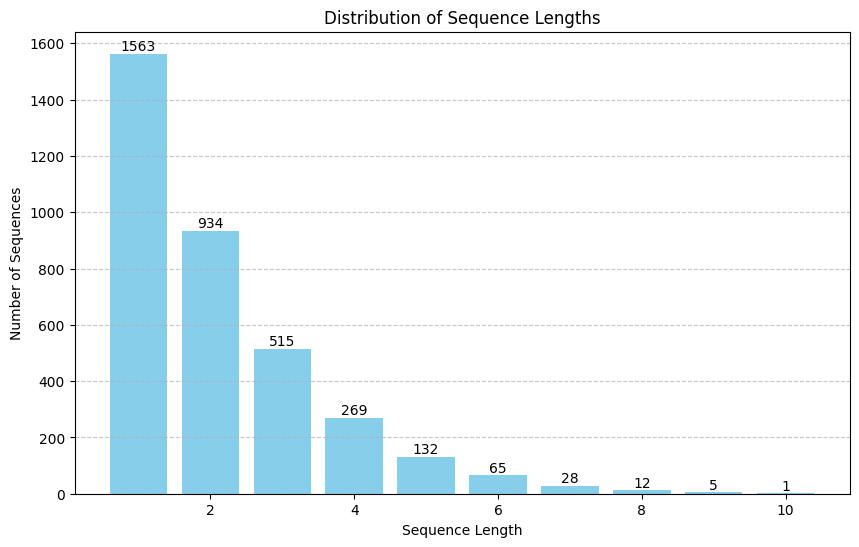

In [38]:
from collections import Counter

# Assuming seq_len_test is a list of sequence lengths
sequence_lengths = seq_len_test

# Count the occurrences of each sequence length
length_counts = Counter(sequence_lengths)

# Get the unique sequence lengths and their counts
unique_lengths = list(length_counts.keys())
counts = list(length_counts.values())

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(unique_lengths, counts, color='skyblue')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Sequences')
plt.title('Distribution of Sequence Lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the numbers on top of the bars
for i, count in enumerate(counts):
    plt.text(unique_lengths[i], count + 1, str(count), ha='center', va='bottom')

plt.show()


In [39]:
# import matplotlib.pyplot as plt

# def plot_sequence_lengths(sequences):
#     # Calculate the lengths of each sequence
#     sequence_lengths = [seq.shape[0] for seq in sequences]

#     # Create the bar chart
#     plt.figure(figsize=(10, 6))
#     plt.bar(range(len(sequence_lengths)), sequence_lengths)
#     plt.xlabel('Sequence Index')
#     plt.ylabel('Sequence Length')
#     plt.title('Lengths of Sequences')
#     plt.show()

# # Plot for train sequences
# plot_sequence_lengths(train_sequences)

# # Plot for validation sequences
# plot_sequence_lengths(val_sequences)

# # Plot for test sequences
# plot_sequence_lengths(test_sequences)


In [40]:
# import plotly.graph_objects as go

# def plot_sequence_length_distribution(sequences):
#     # Calculate the lengths of each sequence
#     sequence_lengths = [seq.shape[0] for seq in sequences]

#     # Calculate the count of sequences for each length
#     sequence_length_counts = {length: sequence_lengths.count(length) for length in range(1, max(sequence_lengths) + 1)}

#     # Create the bar plot
#     fig = go.Figure(data=[go.Bar(x=list(sequence_length_counts.keys()), y=list(sequence_length_counts.values()))])
#     fig.update_layout(title='Distribution of Sequence Lengths',
#                       xaxis_title='Sequence Length',
#                       yaxis_title='Count',
#                       xaxis=dict(dtick=1),
#                       yaxis=dict(type='log', dtick=1))

#     fig.show()

# # Plot for train sequences
# plot_sequence_length_distribution(train_sequences)

# # Plot for validation sequences
# plot_sequence_length_distribution(val_sequences)

# # Plot for test sequences
# plot_sequence_length_distribution(test_sequences)


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking, TimeDistributed, Flatten
from keras import backend as K

# Activate matplotlib interactive mode
plt.ion()


In [42]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from itertools import product

cox_data = filled_data.drop('Serial', axis=1).copy()
cox_data['Event'] = 1


# Assuming 'cox_data' is your DataFrame
# Split your data into a training set and a test set
train_data, test_data = train_test_split(cox_data, test_size=0.2, random_state=42)  # Adjust test_size as needed

best_params = {'alpha': 0.01, 'n_baseline_knots': 2, 'l1_ratio': 0.0}
# After the loop, use the best hyperparameters to train the model
best_alpha = best_params['alpha']
best_n_baseline_knots = best_params['n_baseline_knots']
best_l1_ratio = best_params['l1_ratio']

# Initialize Cox proportional hazards model with the best hyperparameters
coxph_best = CoxPHFitter(alpha=0.01, n_baseline_knots=2)

# Fit the Cox model to the training data with the best hyperparameters
coxph_best.fit(train_data, duration_col='DaysOpen', event_col='Event')

predicted_median_survival_time = coxph_best.predict_expectation(test_data)



In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, Dense
import tensorflow as tf


def get_model(model_type='LSTM', units_1=64, units_2=32, activation='relu', num_dense_layers=2, dense_units=[16, 8], loss='mean_absolute_error', optimizer='adam', learning_rate=0.001):
    if model_type not in ['LSTM', 'BiLSTM', 'RNN', 'GRU']:
        raise ValueError("Invalid model_type. Choose from 'LSTM', 'BiLSTM', 'RNN', or 'GRU'.")

    rnn_layer_1 = None
    rnn_layer_2 = None

    if model_type == 'LSTM':
        rnn_layer_1 = LSTM(units_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
        rnn_layer_2 = LSTM(units_2)
    elif model_type == 'BiLSTM':
        rnn_layer_1 = Bidirectional(LSTM(units_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        rnn_layer_2 = Bidirectional(LSTM(units_2))
    elif model_type == 'RNN':
        rnn_layer_1 = SimpleRNN(units_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
        rnn_layer_2 = SimpleRNN(units_2)
    else:
        raise ValueError("Invalid model_type. Choose from 'LSTM', 'BiLSTM', 'RNN', or 'GRU'.")

    model = Sequential()
    model.add(rnn_layer_1)
    model.add(rnn_layer_2)

    for i in dense_units:
        model.add(Dense(i, activation=activation))

    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics=[loss])
    return model


In [44]:
from IPython.display import clear_output

def train_model(model, train_X, train_y, val_X, val_y, patience=5):

    # Initialize lists for storing MAE values and attention weights
    train_mae = []
    val_mae = []
    train_seq_lengths = [len(seq) for seq in train_X]

    best_val_mae = float('inf')
    best_weights = None
    epochs_without_improvement = 0

    for epoch in range(1, 50):  # You can adjust the maximum number of epochs here
        history = model.fit(train_X, train_y, epochs=1, batch_size=32, validation_data=(val_X, val_y),
                            sample_weight=np.array(train_seq_lengths), verbose=0)

        # Update lists with MAE values
        train_mae.append(history.history['mean_absolute_error'][0])
        val_mae.append(history.history['val_mean_absolute_error'][0])

        # Check for early stopping
        if val_mae[-1] < best_val_mae:
            best_val_mae = val_mae[-1]
            best_weights = model.get_weights()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping after {epoch} epochs.")
                break
        
        print(f"Epoch {epoch} - train MAE: {train_mae[-1]}, val MAE: {val_mae[-1]}")

    # Reset model to best weights
    model.set_weights(best_weights)

    return model


In [45]:
models = {
    "LSTM": None,
    "BiLSTM": None,
    "RNN": None,
}

In [46]:
import time
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

hyperparameters = {
    'units_1': [128, 64],
    'units_2': [64, 32],
    'dense_units': [[16, 8], [32, 16]],
    'learning_rate': [0.001],
    'optimizer': ['adam', 'rmsprop', 'sgd'],
    'activation': ['relu']
}


# Initialize a dictionary to store the best parameters for LSTM and BiLSTM
best_params = {'LSTM': {}, 'BiLSTM': {}, 'RNN': {}}
search_results = {'LSTM': {}, 'BiLSTM': {}, 'RNN': {}}

# Define a function to perform grid search
def grid_search(model_type, hyperparameters):
    best_val_mae = float('inf')
    best_params[model_type] = {}

    records = []

    for config in ParameterGrid(hyperparameters):
        print(f"Evaluating Config: {config}")

        # Create and compile the model
        model = get_model(model_type=model_type, **config)
       
        
        
        # Measure time taken
        start_time = time.time()

        # Train the model
        trained_model = train_model(model, X_train, y_train, X_val, y_val)

        # Calculate time taken
        end_time = time.time()
        training_time = end_time - start_time

        # Get number of epochs
        num_epochs = len(trained_model.history.history['loss'])

        # Evaluate on validation set
        val_mae = trained_model.evaluate(X_val, y_val, verbose=0)[1]

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_params[model_type] = config

        # Store results
        records.append({
            'Config': config,
            'MAE': val_mae,
            'Training Time (s)': training_time,
            'Epochs': num_epochs
        })


    
    return best_params[model_type], records


In [48]:
from sklearn.model_selection import ParameterGrid

# Perform grid search for LSTM
#best_params['LSTM'], search_results['LSTM'] = grid_search('LSTM', hyperparameters)


In [ ]:
best_params['LSTM']

{'activation': 'relu',
 'dense_units': [32, 16],
 'learning_rate': 0.001,
 'optimizer': 'sgd',
 'units_1': 64,
 'units_2': 32}

In [49]:

# Perform grid search for BiLSTM
#best_params['BiLSTM'], search_results['BiLSTM'] = grid_search('BiLSTM', hyperparameters)


In [50]:
best_params['BiLSTM']

In [51]:
#best_params['RNN'], search_results['RNN'] = grid_search('RNN', hyperparameters)


In [52]:
best_params['RNN']

{}

In [53]:
import pandas as pd

# Create a DataFrame to display grid search results
results_df = pd.DataFrame(best_params)

# Display the table
print(results_df)


                  LSTM  BiLSTM  RNN
activation        relu     NaN  NaN
dense_units    [16, 8]     NaN  NaN
learning_rate    0.001     NaN  NaN
optimizer         adam     NaN  NaN
units_1            128     NaN  NaN
units_2             32     NaN  NaN


In [ ]:
# from tensorflow.keras.utils import plot_model

# plot_model(models["RNN"], to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# from IPython.display import Image, display

# # Assuming 'model_plot.png' is the file name
# display(Image(filename='model_plot.png'))

In [54]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    # Use the model to make predictions
    y_pred = model.predict(X_test)

    # Flatten the predictions to 1D arrays
    y_test_flattened = y_test.flatten()
    y_pred_flattened = y_pred.flatten()

    # Calculate evaluation metrics
    mae_val = mean_absolute_error(y_test_flattened, y_pred_flattened)
    mse_val = mean_squared_error(y_test_flattened, y_pred_flattened)
    r2_val = r2_score(y_test_flattened, y_pred_flattened)
    c_index = concordance_index(y_test_flattened, y_pred_flattened)

    return mae_val, mse_val, r2_val, c_index


In [55]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt

def evaluate_cox_model(test_data, predicted_median_survival_time):
    # Extract the observed event times and event indicators from the test data
    observed_times = test_data['DaysOpen']
    event_observed = test_data['Event']

    # Filter out infinite values from observed_times and predicted_median_survival_time
    finite_mask = np.isfinite(observed_times) & np.isfinite(predicted_median_survival_time)
    observed_times_finite = observed_times[finite_mask]
    predicted_median_survival_time_finite = predicted_median_survival_time[finite_mask]

    # Calculate the C-index
    c_index = concordance_index(observed_times_finite, predicted_median_survival_time_finite, event_observed[finite_mask])

    # Calculate Mean Absolute Error (MAE) for Survival, ignoring infinite values
    mae_survival = mean_absolute_error(observed_times_finite, predicted_median_survival_time_finite)

    # Calculate Mean Squared Error (MSE) for Survival, ignoring infinite values
    mse_survival = mean_squared_error(observed_times_finite, predicted_median_survival_time_finite)

    # Calculate R2 score for Survival, ignoring infinite values
    r2_survival = r2_score(observed_times_finite, predicted_median_survival_time_finite)

    return c_index, mae_survival, mse_survival, r2_survival



In [56]:
# Define the number of training runs
num_training_runs = 1

# Create a dictionary to store evaluation results
evaluation_results = {model_type: {metric: [] for metric in [
    'C-Index', 'MAE', 'MSE', 'R2']} for model_type in ['Cox', 'LSTM', 'RNN', 'BiLSTM']}
config = {'LSTM': {'activation': 'relu',
                   'dense_units': [32, 16],
                   'learning_rate': 0.001,
                   'optimizer': 'sgd',
                   'units_1': 64,
                   'units_2': 32},
          'BiLSTM': {'activation': 'relu',
                     'dense_units': [16, 8],
                     'learning_rate': 0.001,
                     'optimizer': 'adam',
                     'units_1': 64,
                     'units_2': 64},
          'RNN': {'activation': 'relu',
                  'dense_units': [16, 8],
                  'learning_rate': 0.001,
                  'optimizer': 'rmsprop',
                  'units_1': 64,
                  'units_2': 32}}
# Perform multiple training runs
for run in range(num_training_runs):
    print(f"Training Run {run + 1}")

    # Train RNN models
    for model_type in ['LSTM', 'BiLSTM', 'RNN']:
        print(f"Training {model_type}")
        X_train, y_train, seq_len_train, X_val, y_val, seq_len_val, X_test, y_test, seq_len_test = create_data(
            filled_data, run)
        # Create and compile the model
        models[model_type] = get_model(
            model_type=model_type, **config[model_type])
        models[model_type] = train_model(
            models[model_type], X_train, y_train, X_val, y_val)

        # Evaluate the model
        mae_val, mse_val, r2_val, c_index = evaluate_model(
            models[model_type], X_test, y_test)
        evaluation_results[model_type].get('MAE').append(mae_val)
        evaluation_results[model_type].get('MSE').append(mse_val)
        evaluation_results[model_type].get('R2').append(r2_val)
        evaluation_results[model_type].get('C-Index').append(c_index)

    # Train Cox model
    train_data, test_data = train_test_split(
        cox_data, test_size=0.2, random_state=run)  # Adjust test_size as needed
    coxph_best = CoxPHFitter(alpha=0.01, n_baseline_knots=2)
    coxph_best.fit(train_data, duration_col='DaysOpen', event_col='Event')

    # Evaluate the Cox model
    cox_evaluation_results = evaluate_cox_model(
        test_data, coxph_best.predict_expectation(test_data))
    for metric, value in zip(['C-Index', 'MAE', 'MSE', 'R2'], cox_evaluation_results):
        evaluation_results['Cox'][metric].append(value)

Training Run 1
Training LSTM
Epoch 1 - train MAE: 96.65888214111328, val MAE: 73.22357940673828
Epoch 2 - train MAE: 67.93146514892578, val MAE: 66.96569061279297
Epoch 3 - train MAE: 21.90613555908203, val MAE: 6.9759650230407715
Epoch 4 - train MAE: 3.987558364868164, val MAE: 2.3483080863952637
Epoch 5 - train MAE: 2.281090021133423, val MAE: 2.024569511413574
Epoch 6 - train MAE: 1.6979093551635742, val MAE: 1.8488104343414307
Epoch 7 - train MAE: 1.4766744375228882, val MAE: 1.215318202972412
Epoch 8 - train MAE: 1.3332817554473877, val MAE: 0.9384189248085022
Epoch 9 - train MAE: 1.1084345579147339, val MAE: 1.0862600803375244
Epoch 10 - train MAE: 1.1642476320266724, val MAE: 0.9112156629562378
Epoch 11 - train MAE: 1.0744978189468384, val MAE: 0.9280034303665161
Epoch 12 - train MAE: 1.043409824371338, val MAE: 1.0014870166778564
Epoch 13 - train MAE: 1.005373239517212, val MAE: 0.774314820766449
Epoch 14 - train MAE: 0.8546832203865051, val MAE: 0.7171757817268372
Epoch 15 - t

In [57]:
!pip install pydot graphviz 


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\gheys\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


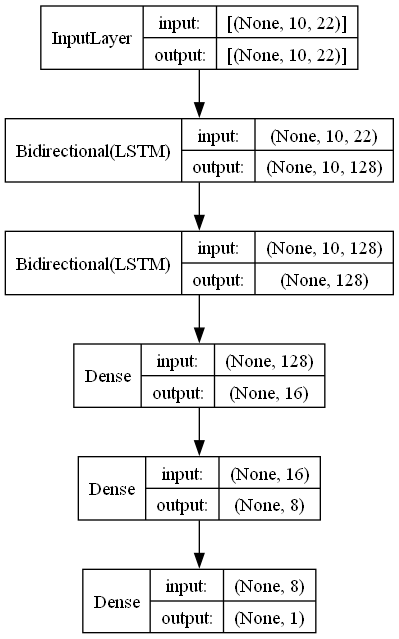

In [67]:
from tensorflow.keras.utils import plot_model

plot_model(models["BiLSTM"], to_file='rnn-architecture.png', show_shapes=True, show_layer_names=False)
# from IPython.display import Image, display

# # Assuming 'model_plot.png' is the file name
#display(Image(filename='model_plot.png'))

In [ ]:
evaluation_results

{'Cox': {'C-Index': [0.7820326012170707,
   0.7951937623647155,
   0.7833319541989471,
   0.7903257371394481,
   0.7883376238665147,
   0.7839754616877588,
   0.7949759975726042,
   0.7839990069633249,
   0.7842828705532489,
   0.7896063106205841],
  'MAE': [69.90111648712323,
   69.68133675861262,
   71.16362791230158,
   70.2961228074764,
   71.71667992818524,
   68.27642033143923,
   67.34853179919342,
   68.67555912759802,
   68.77975033153703,
   70.19941416622335],
  'MSE': [8033.100895218572,
   7784.006551933067,
   8388.725128065911,
   8090.009022088131,
   8650.600211336805,
   7613.701118242715,
   7542.178523854128,
   7615.074544134894,
   7877.294934026463,
   8115.0990835155935],
  'R2': [0.06984135632842214,
   0.10163561529830811,
   0.07490762546245866,
   0.10298154411111704,
   0.07804926236114684,
   0.14295468243473342,
   0.13356773786950515,
   0.06893382036498608,
   0.17387228944400523,
   0.12159612411301479]},
 'LSTM': {'C-Index': [0.9987298111585546,
   0.

In [ ]:
import pandas as pd
metrics = ['C-Index', 'MAE', 'MSE', 'R2']

# Create a list to store the results
results_list = []
model_names = ['Cox', 'RNN', 'LSTM', 'BiLSTM']
# Iterate over training runs
for run in range(num_training_runs):
    # Create a dictionary to store the results of the current run
    run_results = {'Experiment': f'Experiment {run + 1}'}

    # Iterate over models
    for model_type in model_names:
        # Iterate over metrics
        for metric in metrics:
            # Add results to the dictionary
            run_results[f'{model_type} - {metric}'] = evaluation_results[model_type][metric][run]

    # Append the dictionary to the list
    results_list.append(run_results)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)

# Set 'Experiment' column as the index of the DataFrame
results_df.set_index('Experiment', inplace=True)

# Export the DataFrame as a CSV file
#results_df.to_csv('results-2.csv')

results_df



,Cox - C-Index,Cox - MAE,Cox - MSE,Cox - R2,RNN - C-Index,RNN - MAE,RNN - MSE,RNN - R2,LSTM - C-Index,LSTM - MAE,LSTM - MSE,LSTM - R2,BiLSTM - C-Index,BiLSTM - MAE,BiLSTM - MSE,BiLSTM - R2
Experiment,,,,,,,,,,,,,,,,
Experiment 1,0.782033,69.901116,8033.100895,0.069841,0.993261,1.692668,8.636728,0.999218,0.997267,0.944754,4.567974,0.999587,0.995253,1.463236,9.239128,0.999164
Experiment 2,0.795194,69.681337,7784.006552,0.101636,0.993856,1.449016,8.303353,0.999147,0.998385,0.877741,2.049715,0.999789,0.995267,1.262362,7.576143,0.999221
Experiment 3,0.783332,71.163628,8388.725128,0.074908,0.994968,1.382863,5.795280,0.999403,0.998493,0.675416,33.848324,0.996513,0.996146,1.013416,7.425031,0.999235
Experiment 4,0.790326,70.296123,8090.009022,0.102982,0.993040,1.654031,6.820191,0.999316,0.999400,0.422658,0.398697,0.999960,0.995782,1.241599,4.872901,0.999511
Experiment 5,0.788338,71.716680,8650.600211,0.078049,0.995160,1.377759,5.802099,0.999331,0.997503,0.918539,12.561434,0.998552,0.995852,1.489549,8.086245,0.999068
Experiment 6,0.783975,68.276420,7613.701118,0.142955,0.995261,1.301571,4.911967,0.999466,0.998068,0.728930,1.571959,0.999829,0.995876,1.300765,6.809814,0.999260
Experiment 7,0.794976,67.348532,7542.178524,0.133568,0.996960,1.151339,3.062473,0.999696,0.998970,0.653781,1.146726,0.999886,0.996315,1.392467,8.171104,0.999188
Experiment 8,0.783999,68.675559,7615.074544,0.068934,0.992192,1.860387,9.521753,0.998976,0.998450,0.759618,2.340911,0.999748,0.996649,1.101289,5.198319,0.999441
Experiment 9,0.784283,68.779750,7877.294934,0.173872,0.994283,1.737534,7.949063,0.999238,0.998504,0.726411,1.465014,0.999860,0.995672,1.244804,6.822868,0.999346


In [71]:
# Define max sequence length
max_sequence_length = 10

# Initialize a dictionary to store MAE values for each model
mae_values_dict = {model_type: [] for model_type in ['LSTM', 'BiLSTM', 'RNN']}

In [72]:
def evaluate_on_actual_sequence_length(model, X, y, seq_lengths):
    mae_values = []

    for seq_length in range(1, max_sequence_length + 1):
        # Filter sequences with the specified length
        indices = [i for i, seq_len in enumerate(seq_lengths) if seq_len == seq_length]
        if len(indices) > 0:
            X_subset = X[indices]
            y_subset = y[indices]

            # Calculate MAE
            mae = model.evaluate(X_subset, y_subset, verbose=0)[1]
            mae_values.append(mae)
        else:
            mae_values.append(None)

    return mae_values

In [73]:
# Evaluate each model
for model_type in ['LSTM', 'BiLSTM', 'RNN']:
    model = models[model_type]
    mae_values = evaluate_on_actual_sequence_length(model, X_test, y_test, seq_len_test)
    mae_values_dict[model_type] = mae_values
    print(mae_values)

[0.6096344590187073, 0.7315731048583984, 0.7770542502403259, 0.7698673009872437, 0.7625437378883362, 0.8572213649749756, 0.7803309559822083, 0.9424769282341003, 1.2528457641601562, 0.4807891845703125]
[1.0824284553527832, 1.2079246044158936, 1.269924283027649, 1.3997105360031128, 1.2451937198638916, 1.2633600234985352, 1.324797511100769, 1.1234315633773804, 4.852076530456543, 9.685379028320312]
[1.2813563346862793, 1.8049486875534058, 1.883217692375183, 2.0248680114746094, 2.1583664417266846, 2.290334463119507, 2.3216521739959717, 1.990277647972107, 1.6300079822540283, 0.46126556396484375]


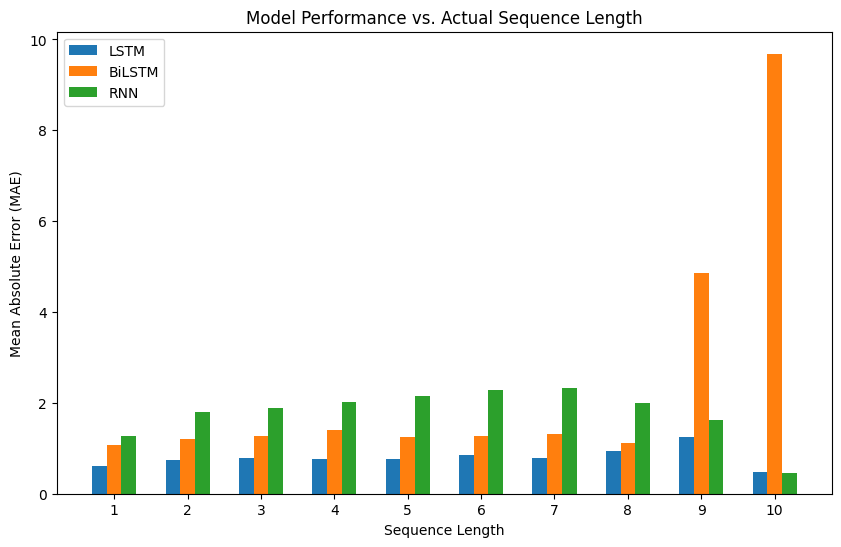

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
x = np.arange(1, max_sequence_length + 1)  # X-axis values (sequence lengths)

# Define the width of the bars
bar_width = 0.2

for i, (model_type, mae_values) in enumerate(mae_values_dict.items()):
    valid_mae_values = [mae for mae in mae_values if mae is not None]  # Filter out None values
    valid_x = x[:len(valid_mae_values)]
    plt.bar(valid_x + i * bar_width, valid_mae_values, width=bar_width, label=model_type)

plt.xlabel('Sequence Length')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model Performance vs. Actual Sequence Length')
plt.xticks(x + bar_width * (len(mae_values_dict.keys()) - 1) / 2, x)  # Adjust the x-axis ticks
plt.legend()
plt.show()


111/111 [==============================] - 1s 7ms/step
MAE After Permutition of AgeAtCalvingInDays : 1.8714677555464456
111/111 [==============================] - 1s 7ms/step
MAE After Permutition of AverageBodyScore : 1.8225217966239362
111/111 [==============================] - 1s 8ms/step
MAE After Permutition of AverageMotionScore : 1.867498577097987
111/111 [==============================] - 1s 6ms/step
MAE After Permutition of InbreedingCoefficient : 1.9213444151819592
111/111 [==============================] - 1s 6ms/step
MAE After Permutition of StillBirth : 1.903199475690151
111/111 [==============================] - 1s 6ms/step
MAE After Permutition of Abortion : 1.9599714039108005
111/111 [==============================] - 1s 6ms/step
MAE After Permutition of MultiBirth : 1.9083277922882949
111/111 [==============================] - 1s 7ms/step
MAE After Permutition of NaturalBreeding : 1.963397721095491
111/111 [==============================] - 1s 7ms/step
MAE After Permut

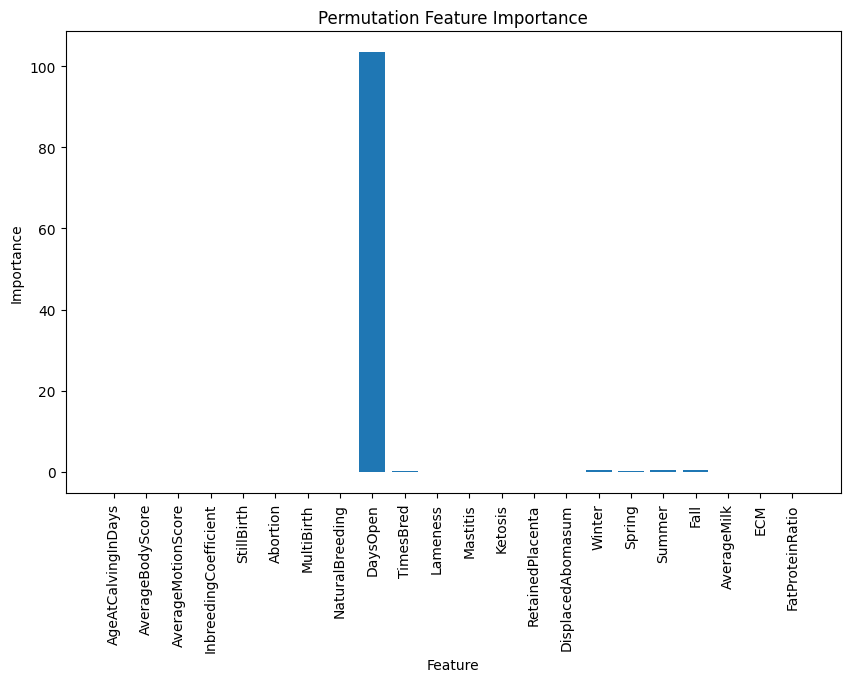

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Assume X_test and y_test are your test data
# Assume model is your trained LSTM model

# Compute the baseline performance of the model
baseline_mae = mean_absolute_error(y_test, model.predict(X_test))

# Initialize an array to hold the feature importances
feature_importances = np.zeros(X_test.shape[2])

# Loop over the features
for i in range(X_test.shape[2]):
    # Make a copy of the test data
    X_test_permuted = X_test.copy()

    # Permute the values of the feature
    for j in range(X_test.shape[1]):
        np.random.shuffle(X_test_permuted[:, j, i])

    # Compute the performance of the model on the permuted data
    mae_permuted = mean_absolute_error(y_test, model.predict(X_test_permuted))

    print(f"MAE After Permutition of {feature_columns[i]} : {mae_permuted}")

    # The feature importance is the decrease in performance
    feature_importances[i] =  mae_permuted - baseline_mae

# Plot the feature importances
# Plot the feature importances
plt.figure(figsize=(10,6))
plt.bar(feature_columns, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance')
plt.xticks(rotation='vertical')  # Rotate feature names for readability
plt.show()

In [ ]:
import pandas as pd

# Create a DataFrame with feature names and importances
df_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Display the DataFrame
df_importances

,Feature,Importance
8,DaysOpen,103.392442
15,Winter,0.481887
17,Summer,0.474384
18,Fall,0.359921
9,TimesBred,0.319509
16,Spring,0.313882
7,NaturalBreeding,0.043498
5,Abortion,0.040071
13,RetainedPlacenta,0.017924
14,DisplacedAbomasum,0.011672


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
import plotly.graph_objects as go

# Evaluate the model on the test data
score = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', score)

# Use the model to make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Median Absolute Error (MedAE):', medae)
print('R-squared (R2):', r2)



111/111 [==============================] - 1s 8ms/step - loss: 1.9199 - mean_absolute_error: 1.9199
Test loss: [1.9198997020721436, 1.9198997020721436]
111/111 [==============================] - 1s 7ms/step
Mean Absolute Error (MAE): 1.9199001359805123
Mean Squared Error (MSE): 12.351155844091059
Median Absolute Error (MedAE): 1.0299186706542969
R-squared (R2): 0.998889116750783


In [ ]:
# Round the prediction values to natural numbers
lstm_pred_rounded = np.round(models['LSTM'].predict(X_test).flatten())
bi_lstm_pred_rounded = np.round(models['BiLSTM'].predict(X_test).flatten())

111/111 [==============================] - 1s 7ms/step


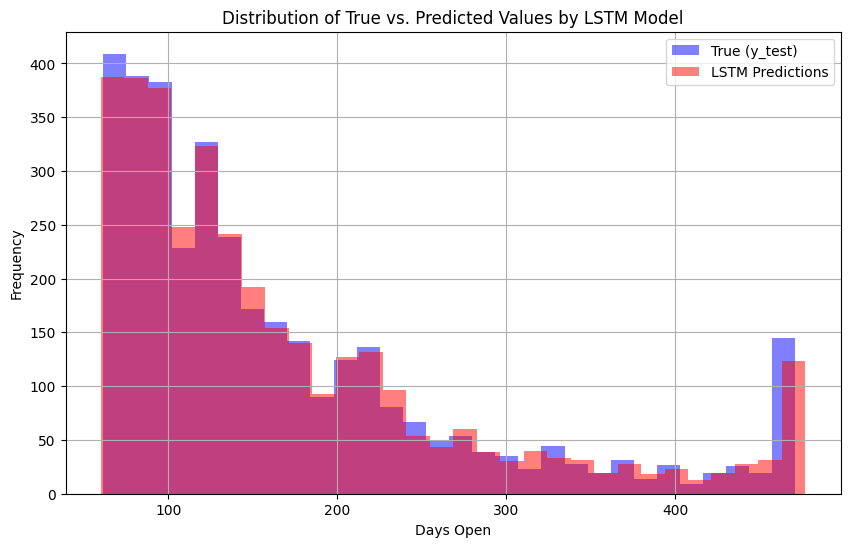

In [ ]:
# Assuming y_test, lstm_pred, and bilstm_pred are numpy arrays
plt.figure(figsize=(10, 6))

# Plot the distribution of y_test in blue
plt.hist(y_test, bins=30, alpha=0.5, color='blue', label='True (y_test)')

# Plot the distribution of LSTM predictions in red
plt.hist(lstm_pred_rounded, bins=30, alpha=0.5, color='red', label='LSTM Predictions')



plt.title('Distribution of True vs. Predicted Values by LSTM Model')
plt.xlabel('Days Open')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()


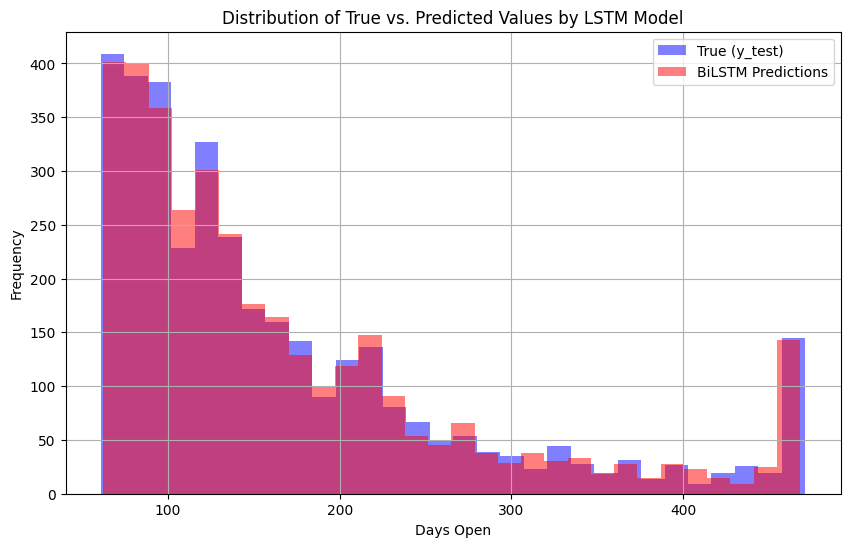

In [ ]:
# Assuming y_test, lstm_pred, and bilstm_pred are numpy arrays
plt.figure(figsize=(10, 6))

# Plot the distribution of y_test in blue
plt.hist(y_test, bins=30, alpha=0.5, color='blue', label='True (y_test)')

# Plot the distribution of LSTM predictions in red
plt.hist(bi_lstm_pred_rounded, bins=30, alpha=0.5, color='red', label='BiLSTM Predictions')



plt.title('Distribution of True vs. Predicted Values by LSTM Model')
plt.xlabel('Days Open')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()


 10/159 [>.............................] - ETA: 0s

159/159 [==============================] - 1s 6ms/step


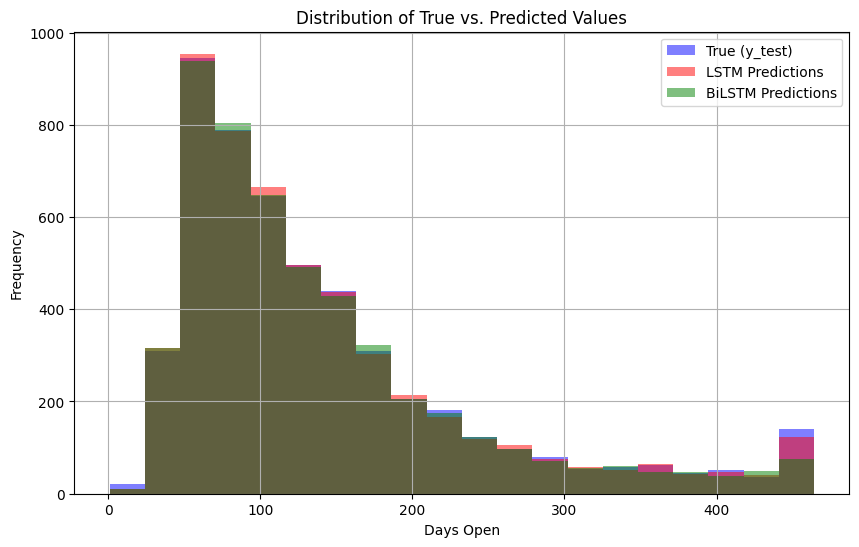

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Round the prediction values to natural numbers
lstm_pred_rounded = np.round(models['LSTM'].predict(X_test).flatten())
bi_lstm_pred_rounded = np.round(models['BiLSTM'].predict(X_test).flatten())

# Assuming y_test, lstm_pred, and bilstm_pred are numpy arrays
plt.figure(figsize=(10, 6))

# Plot the distribution of y_test in blue
plt.hist(y_test, bins=20, alpha=0.5, color='blue', label='True (y_test)', histtype='bar')

# Define the bin edges for better alignment
bin_edges = np.histogram(y_test, bins=20)[1]

# Calculate width for each bin
bin_width = bin_edges[1] - bin_edges[0]

# Plot the distribution of LSTM predictions in red
plt.hist(lstm_pred_rounded, bins=bin_edges, alpha=0.5, color='red', label='LSTM Predictions', histtype='bar', width=bin_width)

# Plot the distribution of BiLSTM predictions in green
plt.hist(bi_lstm_pred_rounded, bins=bin_edges, alpha=0.5, color='green', label='BiLSTM Predictions', histtype='bar', width=bin_width)

plt.title('Distribution of True vs. Predicted Values')
plt.xlabel('Days Open')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.show()


C:\Users\gheys\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


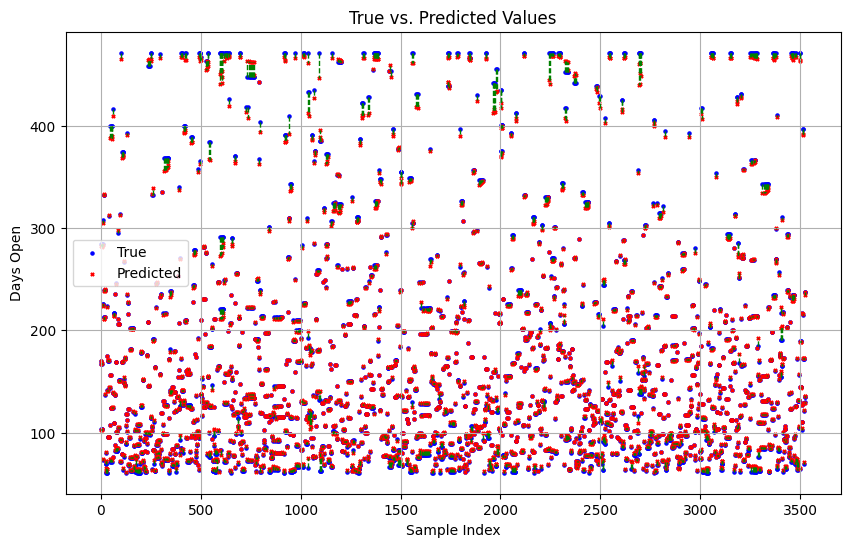

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are numpy arrays
x_values = np.arange(len(y_test))

# Round the prediction values to natural numbers
y_pred_rounded = np.round(y_pred.flatten())

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot true values in blue with smaller dots (s parameter)
plt.scatter(x_values, y_test, label='True', color='blue', marker='o', s=5)

# Plot predicted values (rounded) in red with smaller dots (s parameter)
plt.scatter(x_values, y_pred_rounded, label='Predicted', color='red', marker='x', s=5)

# Draw lines connecting true and predicted values
for x, yt, yp in zip(x_values, y_test, y_pred_rounded):
    plt.plot([x, x], [yt, yp], color='green', linestyle='--', linewidth=1)

plt.title('True vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Days Open')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:

# Distribution of true values and predicted values
fig4 = go.Figure()

# Plot histogram of true values in blue
fig4.add_trace(go.Histogram(x=y_test, nbinsx=20, name='True', marker=dict(color='blue'), opacity=0.7))

# Plot histogram of predicted values in red
fig4.add_trace(go.Histogram(x=y_pred.flatten(), nbinsx=20, name='Predicted', marker=dict(color='red'), opacity=0.7))

fig4.update_layout(title='Distribution of True vs. Predicted Values',
                   xaxis_title='Days Open',
                   yaxis_title='Frequency',
                   barmode='overlay')

fig4.update_traces(opacity=0.75)


fig4.show()


In [ ]:
print(y_pred.squeeze().shape, y_test.squeeze().shape)

(5087,) (5087,)


In [ ]:


# Calculate percentage of predicted values greater than actual test values
greater_count = np.sum(y_pred.squeeze() > y_test.squeeze())
greater_percentage = greater_count / y_pred.squeeze().shape[0] * 100

# Calculate percentage of predicted values lower than actual test values
lower_count = np.sum(y_pred.squeeze() < y_test.squeeze())
lower_percentage = lower_count / y_pred.squeeze().shape[0] * 100

# Create a bar chart
fig = go.Figure(data=[go.Bar(x=['Greater', 'Lower'], y=[greater_percentage, lower_percentage])])
fig.update_layout(title='Percentage of Predicted Values Greater/Lower Than Actual Test Values')
fig.show()